There are 2 parts in this Notebook.

1.   [Finding the best samples](#Section1)
2.   [Training on those samples](#Section2)
3.   [Training on random samples](#Section3)



<a name="Section1"></a>
# Finding most valuable $n(=500)$ data samples from $60,000$ samples.

## Imports

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from torch import save, load, device, randint, split, cuda#, inference_mode
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax.scipy.special import logsumexp

## Dataset

In [2]:
def dataset_with_indices(cls):
    """
    Modifies the given Dataset class to return a tuple data, target, index
    instead of just data, target.
    """

    def __getitem__(self, index):
        data, target = cls.__getitem__(self, index)
        return data, target, index

    return type(cls.__name__, (cls,), {
        '__getitem__': __getitem__,
    })
# https://discuss.pytorch.org/t/how-to-retrieve-the-sample-indices-of-a-mini-batch/7948/19

In [3]:
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
# train_data = MNIST("./", transform=transform, download=True)
MNISTWithIndices = dataset_with_indices(MNIST)
train_data = MNISTWithIndices("./", transform=transform, download=True)
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [4]:
train_images, train_labels, train_indices = next(iter(DataLoader(train_data, len(train_data), shuffle=True)))
train_images.shape, train_labels.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([60000]))

In [5]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)

In [6]:
num_classes = 10
train_images = jnp.array(train_images).reshape(-1, 28*28)
train_labels = one_hot(jnp.array(train_labels), num_classes)
print("Train Images Shape", train_images.shape)
print("Train Labels Shape", train_labels.shape)

Train Images Shape (60000, 784)
Train Labels Shape (60000, 10)


In [7]:
def iterate_minibatches(inputs, targets, batchsize):
    assert inputs.shape[0] == targets.shape[0]
    assert train_images.shape[0] % batchsize == 0
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

## Model

In [8]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=0.1):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 128, 32, 10]
step_size = 0.01
num_epochs = 8
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.PRNGKey(0))

In [9]:
for x in params:
  print(f"Weight: {x[0].shape}\tBias: {x[1].shape}")

Weight: (512, 784)	Bias: (512,)
Weight: (128, 512)	Bias: (128,)
Weight: (32, 128)	Bias: (32,)
Weight: (10, 32)	Bias: (10,)


In [10]:
from jax.scipy.special import logsumexp

def relu(x):
    return jnp.maximum(0, x)

def forward(params, x):
    # per-example predictions
    activations = x
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = relu(outputs)

    final_w, final_b = params[-1]
    logits = jnp.dot(final_w, activations) + final_b
    return logits - logsumexp(logits) # Basically log softmax

@grad
def loss(params, x, y):
    preds = forward(params, x)
    return -jnp.sum(preds * y)

In [11]:
batched_loss = jit(vmap(loss, in_axes=(None, 0,0)))

In [12]:
# BatchSize = 1000
# loader = iterate_minibatches(train_images, train_labels, batchsize=BatchSize)

## Too much memory Consumption

In [13]:
# gradients = [[None, None] for i in range(len(params))]
# for i, batch in enumerate(loader):
#     images, labels = batch
#     gradient = batched_loss(params, images, labels)
#     if gradients[0][0] is not None:
#         for j in range(len(params)):
#             gradients[j][0] = np.concatenate([gradients[j][0], np.asarray(gradient[j][0])])
#             gradients[j][1] = np.concatenate([gradients[j][1], np.asarray(gradient[j][1])])
#     else:
#         for j in range(len(params)):
#             gradients[j][0] = np.asarray(gradient[j][0])
#             gradients[j][1] = np.asarray(gradient[j][1])
#     break

In [14]:
# net_gradients = [[None, None] for i in range(len(params))]
# for j in range(len(params)):
#     net_gradients[j][0] = jnp.mean(gradients[j][0], axis=0)
#     net_gradients[j][1] = jnp.mean(gradients[j][1], axis=0)

## Finding Net Gradient first

In [20]:
def get_net_gradeints(params, images, labels, batch_size):
    net_gradients = [[None, None] for i in range(len(params))]
    loader = iterate_minibatches(images, labels, batchsize=batch_size)
    progress_bar = tqdm(enumerate(loader), total = labels.shape[0]//batch_size, desc="Net Gradients", leave=False)
    for i, batch in progress_bar:
        images, labels = batch
        gradient = batched_loss(params, images, labels)
        if net_gradients[0][0] is not None:
            for j in range(len(params)):
                net_gradients[j][0] += gradient[j][0].sum(axis=0)
                net_gradients[j][1] += gradient[j][1].sum(axis=0)
        else:
            for j in range(len(params)):
                net_gradients[j][0] = gradient[j][0].sum(axis=0)
                net_gradients[j][1] = gradient[j][1].sum(axis=0)

    for j in range(len(params)):
        net_gradients[j][0] /= labels.shape[0]
        net_gradients[j][1] /= labels.shape[0]
    return net_gradients
# net_gradients = get_net_gradeints(params, train_images, train_labels, BatchSize)

Finding Cosine Similarity between gradients per sample with gradient over entire dataset

In [21]:
@jit
def cosinesimilarity(a,b):
    return jnp.divide(jnp.dot(a, b.T),  (jnp.linalg.norm(a) * jnp.linalg.norm(b)))

In [22]:
cs = vmap(cosinesimilarity, in_axes=(0, None))

In [23]:
def get_similarities(params, images, labels, batch_size, net_gradients):
    loader = iterate_minibatches(images, labels, batchsize=batch_size)
    similarities = []
    progress_bar = tqdm(enumerate(loader), total = labels.shape[0]//batch_size, desc="Per Sample Gradient Similarity", leave=False)
    for i, batch in progress_bar:
        imgs, label = batch
        gradient = batched_loss(params, imgs, label)
        sim=0
        for j in range(len(params)):
            sim += cs(gradient[j][0].reshape(batch_size,-1), net_gradients[j][0].reshape(1,-1))
        similarities.append(sim)
    return jnp.concatenate(similarities)
# similarities = get_similarities(params, train_images, train_labels, BatchSize, net_gradients)

## Finding top n similar samples for k iterations

In [24]:
iterations = 100
topn = 500
BatchSize =300
good_inds = []
for k in tqdm(range(iterations), desc="Iterations"):
    params = init_network_params(layer_sizes, random.PRNGKey(k))
    net_gradients = get_net_gradeints(params, train_images, train_labels, BatchSize)
    similarities = get_similarities(params, train_images, train_labels, BatchSize, net_gradients)
    
    inds = np.argpartition(-np.asarray(similarities).squeeze(), topn)[:topn]
    good_inds.append(inds)

good_inds = np.concatenate(good_inds)

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/200 [00:00<?, ?it/s]

In [25]:
good_inds.shape

(50000,)

In [26]:
values, counts = np.unique(good_inds, return_counts=True)
# ref:https://stackoverflow.com/a/28736715/13730689

In [27]:
inds = np.argpartition(-counts, kth=topn)[:topn]

In [28]:
jnp.unique(train_labels[inds].argmax(axis=1), return_counts=True)

(DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 DeviceArray([53, 56, 61, 47, 44, 43, 43, 52, 65, 36], dtype=int32))

In [29]:
best_inds = train_indices[inds]
save(best_inds, f"best_inds_{topn}.pt")

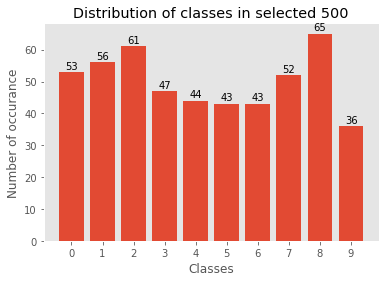

In [30]:
plt.figure()
unique_and_counts = jnp.unique(train_labels[inds].argmax(axis=1), return_counts=True)
plt.bar(*unique_and_counts)
plt.xticks(unique_and_counts[0])
plt.xlabel("Classes")
plt.ylabel('Number of occurance')
plt.title(f"Distribution of classes in selected {topn}")
plt.grid(linestyle='--')
for i, v in enumerate(unique_and_counts[1]):
    plt.text(i-0.2, v + 1, str(v))
plt.show()

<a name="Section2"></a>
# Training on Sampled Data

In [31]:
Device = device("cuda:0" if cuda.is_available() else "cpu")
print(Device)

cuda:0


## Dataset

In [32]:
# best_inds = torch.load("best_inds.pt")

In [33]:
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
data = Subset(MNIST("./", transform=transform, download=True), best_inds)
test_data = MNIST("./", False, transform=transform, download=True)

In [34]:
images, labels = next(iter(DataLoader(data, len(data), shuffle=True)))
images.shape, labels.shape

(torch.Size([500, 1, 28, 28]), torch.Size([500]))

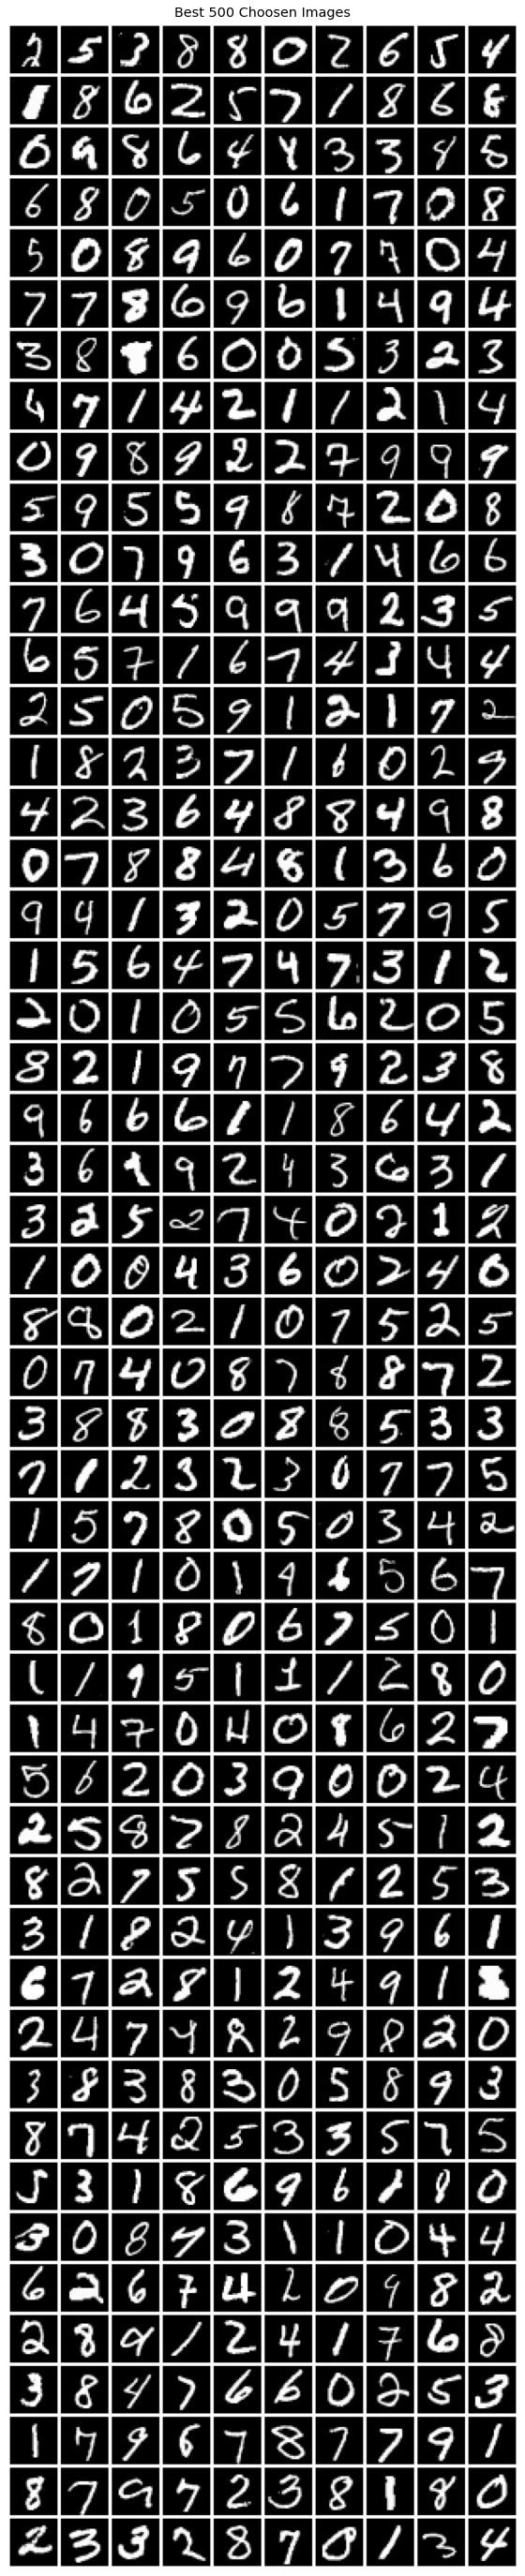

In [35]:
img_grid = make_grid(images, 10, pad_value=1, normalize=True)
plt.figure(figsize=(10, topn//10))
plt.title(f"Best {topn} Choosen Images")
plt.imshow(img_grid.permute(1,2,0))
plt.axis('off')
plt.show()

In [36]:
images = images.reshape(len(data), -1).to(Device)
labels = labels.to(Device)
images.shape

torch.Size([500, 784])

In [37]:
val_size = int(0.1*labels.shape[0])
sections = (labels.shape[0]-val_size, val_size)
train_images, val_images = split(images, sections)
train_labels, val_labels = split(labels, sections)
print("Train Set: ", train_images.shape, train_labels.shape)
print("Val Set: ", val_images.shape, val_labels.shape)

Train Set:  torch.Size([450, 784]) torch.Size([450])
Val Set:  torch.Size([50, 784]) torch.Size([50])


In [38]:
test_loader = DataLoader(test_data, batch_size=200, num_workers=2, pin_memory=True)

## Model

In [39]:
def get_layers():
    layers = []
    for i in range(len(layer_sizes)-1):
        layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
        layers.append(nn.ReLU())
    layers.insert(2, nn.Dropout())
    layers.insert(5, nn.Dropout())
    layers[-1] = nn.LogSoftmax(1)
    return layers
layers = get_layers()
model = nn.Sequential(*layers).to(Device)

In [40]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight)
        nn.init.normal_(m.bias)
        m.weight.data.multiply_(0.1)
        m.bias.data.multiply_(0.1)
model.apply(init_weights)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=128, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=10, bias=True)
  (9): LogSoftmax(dim=1)
)

## Training Utils

In [41]:
from torch import no_grad

In [42]:
@no_grad()
def test(loader, model):
    model.eval()
    correct = 0
    for (images, labels) in loader:
        images, labels = images.to(Device).reshape(images.shape[0], -1), labels.to(Device)
        output = model(images)
        acc = output.argmax(dim=1).eq(labels).sum().item()
        correct += acc
    return correct

In [43]:
@no_grad()
def val(val_i, val_l, model, criterion):
    model.eval()
    output = model(val_i)
    loss = criterion(output, val_l)
    acc = output.argmax(dim=1).eq(val_l).float().mean().item()
    return loss, acc

In [44]:
lr = 0.05
optimizer = SGD(model.parameters(), lr=lr, weight_decay=0.01)
criterion = nn.NLLLoss()

In [45]:
Epochs = 500

In [46]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=10, min_delta=1e-4):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_acc = None
        self.early_stop = False
    def __call__(self, val_acc):
        if  val_acc < 0.6:
            return
        if self.best_acc == None:
            self.best_acc = val_acc
        elif val_acc - self.best_acc > self.min_delta:
            self.best_acc = val_acc
            # reset counter if validation acc improves
            self.counter = 0
        elif val_acc - self.best_acc < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True
# ref : https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/

## Training Loop

In [47]:
early_stopping = EarlyStopping()
losses, accs, val_losses, val_accs = [], [], [], []
for epoch in tqdm(range(Epochs)):
    model.train()
    optimizer.zero_grad(set_to_none=True)
    output = model(train_images)
    loss = criterion(output, train_labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    acc = output.argmax(dim=1).eq(train_labels).float().mean().item()
    accs.append(acc)
    val_loss, val_acc = val(val_images, val_labels, model, criterion)
    val_losses.append(val_loss.item())
    val_accs.append(val_acc)
    early_stopping(val_acc)
    # print(f"Epoch[{epoch+1:4}] Val_Loss: {val_loss:.3f}\tVal_Acc: {val_acc:.3f}")
    if epoch % 50 == 0:
        
        correct = test(test_loader, model)
        print(f"Epoch[{epoch+1:4}] Loss: {loss.item():.2f}\tAccuracy: {acc*100 :.3f}\tVal_Loss: {val_loss:.3f}\tVal_Acc: {val_acc*100:.3f}")
        print(f"Epoch[{epoch+1:4}] Test Accuracy: {(correct / len(test_data))*100 :.3f}")
    if early_stopping.early_stop:
        print(f"Trained for {epoch+1} Epochs.")
        break

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 4.28	Accuracy: 8.667	Val_Loss: 2.429	Val_Acc: 12.000
Epoch[   1] Test Accuracy: 13.670
Epoch[  51] Loss: 1.73	Accuracy: 40.889	Val_Loss: 1.459	Val_Acc: 58.000
Epoch[  51] Test Accuracy: 63.530
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 7 of 10
INFO: Early stopping counter 8 of 10
INFO: Early stopping counter 9 of 10
INFO: Early stopping counter 10 of 10
INFO: Early stopping
Trained for 84 Epochs.


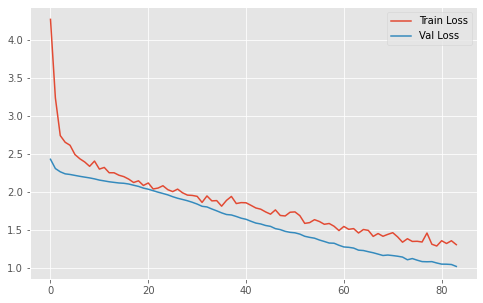

In [48]:
plt.figure(figsize=(8,5))
plt.plot(losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.savefig(f"LossCurve_greedy{topn}")
plt.show()

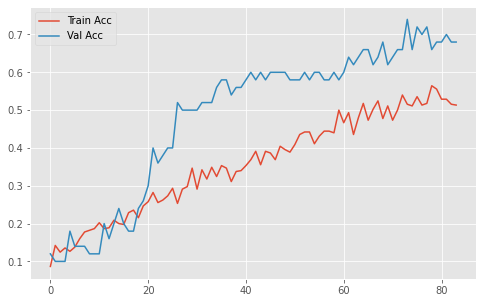

In [49]:
plt.figure(figsize=(8,5))
plt.plot(accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.savefig(f"AccCurve_greedy{topn}")
plt.show()

In [50]:
model.eval()
output = model(train_images)
acc = output.argmax(dim=1).eq(train_labels).float().mean().item()
print("Accuracy on Train Set", acc*100)
correct = test(test_loader, model)
print(correct, 'correctly labeled out of', len(test_data))
test_acc = correct / len(test_data) * 100
print('Accuracy on Test Set:', test_acc)

Accuracy on Train Set 75.11111497879028
6932 correctly labeled out of 10000
Accuracy on Test Set: 69.32000000000001


In [51]:
save(model.state_dict(), f"Greedy_Model_{topn}n_Epochs_{Epochs}_Early_Stop_{epoch+1}_Test_Acc_{int(test_acc)}.pth")

<a name="Section3"></a>
# Training on Randomly Sampled Data

In [52]:
Rand_Train_Acc, Rand_Val_Acc = [], []

## Dataset

In [53]:
inds = randint(0, 60000, (topn,))
inds.shape

torch.Size([500])

In [54]:
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
data = Subset(MNIST("./", transform=transform, download=True), inds)
test_data = MNIST("./", False, transform=transform, download=True)

In [55]:
images, labels = next(iter(DataLoader(data, len(data), shuffle=True)))
images.shape, labels.shape

(torch.Size([500, 1, 28, 28]), torch.Size([500]))

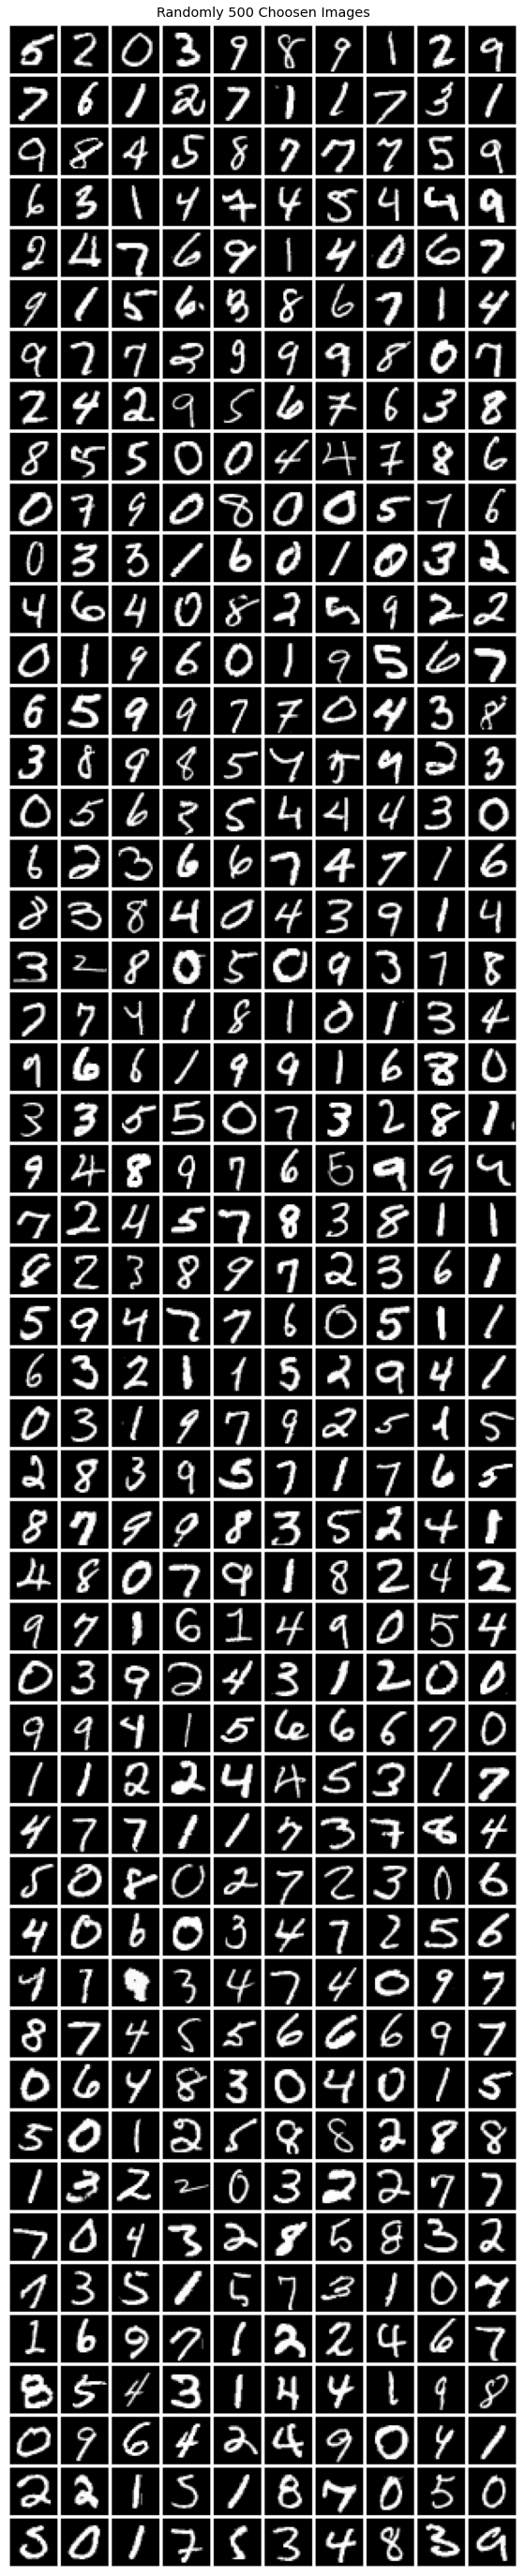

In [56]:
img_grid = make_grid(images, 10, pad_value=1, normalize=True)
plt.figure(figsize=(10, topn//10))
plt.title(f"Randomly {topn} Choosen Images")
plt.imshow(img_grid.permute(1,2,0))
plt.axis('off')
plt.show()

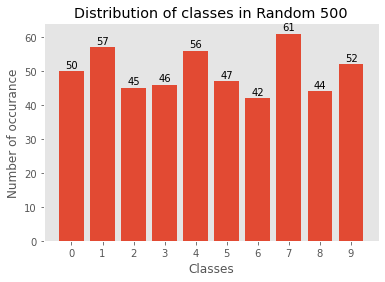

In [57]:
plt.figure()
unique_and_counts = np.unique(labels, return_counts=True)
plt.bar(*unique_and_counts)
plt.xticks(unique_and_counts[0])
plt.xlabel("Classes")
plt.ylabel('Number of occurance')
plt.title("Distribution of classes in Random 500")
plt.grid(linestyle='--')
for i, v in enumerate(unique_and_counts[1]):
    plt.text(i-0.2, v + 1, str(v))
plt.show()

In [58]:
images = images.reshape(len(data), -1).to(Device)
labels = labels.to(Device)
images.shape

torch.Size([500, 784])

In [59]:
val_size = int(0.1*labels.shape[0])
sections = (labels.shape[0]-val_size, val_size)
train_images, val_images = split(images, sections)
train_labels, val_labels = split(labels, sections)
print("Train Set: ", train_images.shape, train_labels.shape)
print("Val Set: ", val_images.shape, val_labels.shape)

Train Set:  torch.Size([450, 784]) torch.Size([450])
Val Set:  torch.Size([50, 784]) torch.Size([50])


In [60]:
test_loader = DataLoader(test_data, batch_size=200, num_workers=2, pin_memory=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 4.70	Accuracy: 10.000	Val_Loss: 2.475	Val_Acc: 10.000
Epoch[   1] Test Accuracy: 12.050
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
Epoch[  51] Loss: 1.77	Accuracy: 38.222	Val_Loss: 1.345	Val_Acc: 66.000
Epoch[  51] Test Accuracy: 62.050
INFO: Early stopping counter 7 of 10
INFO: Early stopping counter 8 of 10
INFO: Early stopping counter 9 of 10
INFO: Early stopping counter 10 of 10
INFO: Early stopping
Trained for 55 Epochs.


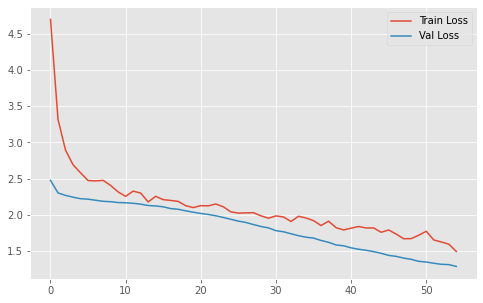

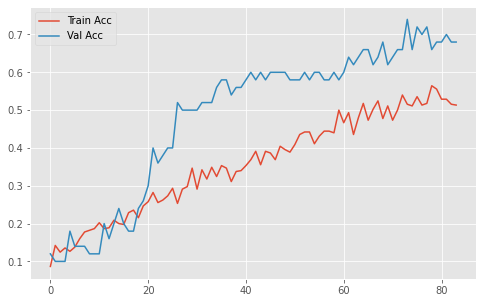

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 3.93	Accuracy: 10.667	Val_Loss: 2.271	Val_Acc: 14.000
Epoch[   1] Test Accuracy: 14.600
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
Epoch[  51] Loss: 1.59	Accuracy: 44.444	Val_Loss: 1.177	Val_Acc: 66.000
Epoch[  51] Test Accuracy: 66.580
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 7 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early

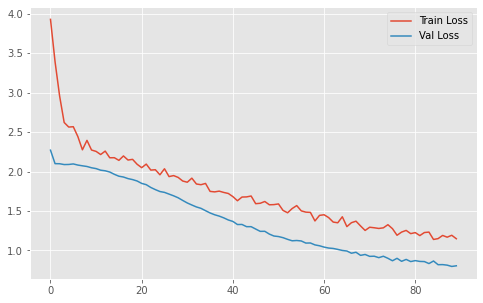

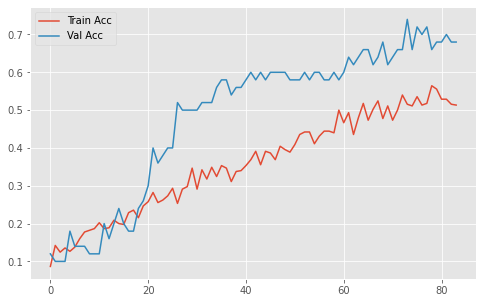

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 4.30	Accuracy: 11.778	Val_Loss: 2.534	Val_Acc: 18.000
Epoch[   1] Test Accuracy: 12.430
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
Epoch[  51] Loss: 1.57	Accuracy: 45.111	Val_Loss: 1.263	Val_Acc: 70.000
Epoch[  51] Test Accuracy: 69.730
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 7 of 10
INFO: Early stopping counter 8 of 10
INFO: Early stopping counter 9 of 10
INFO: Early stopping counter 10 of 10
INFO: Early stopping
Trained for 59 Epochs.


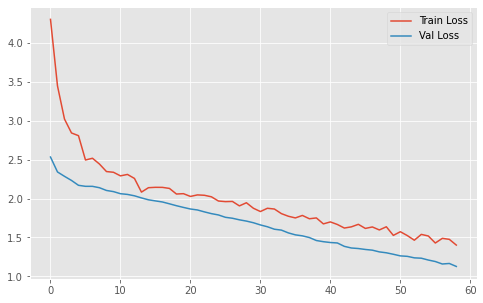

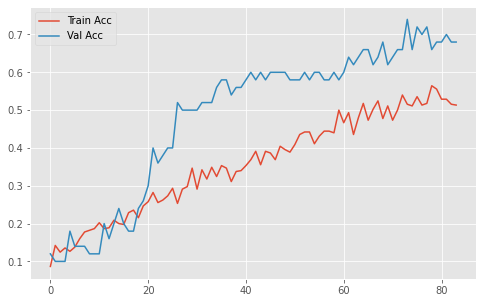

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 4.61	Accuracy: 6.667	Val_Loss: 2.348	Val_Acc: 10.000
Epoch[   1] Test Accuracy: 9.950
Epoch[  51] Loss: 1.55	Accuracy: 45.333	Val_Loss: 1.382	Val_Acc: 54.000
Epoch[  51] Test Accuracy: 56.210
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 7 of 10
INFO: Early stopping counter 8 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 7 of 10
INFO: Early stopping counter 8 of 10
INFO: Early stopping counter 9 of 10
INFO: Early stopping counter 10 of 10
INFO: Early 

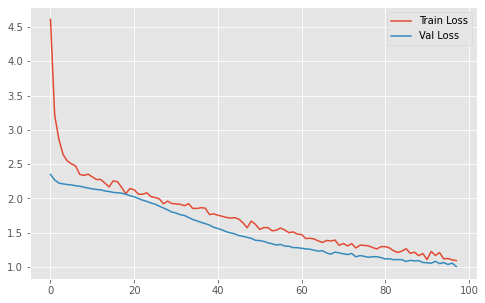

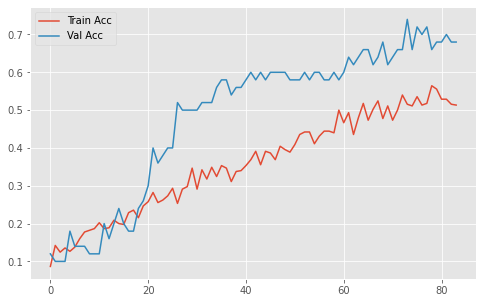

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 5.21	Accuracy: 9.778	Val_Loss: 2.625	Val_Acc: 18.000
Epoch[   1] Test Accuracy: 15.260
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 1 of 10
Epoch[  51] Loss: 1.68	Accuracy: 41.556	Val_Loss: 1.289	Val_Acc: 70.000
Epoch[  51] Test Accuracy: 61.870
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early 

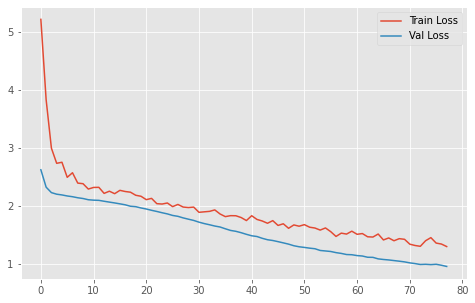

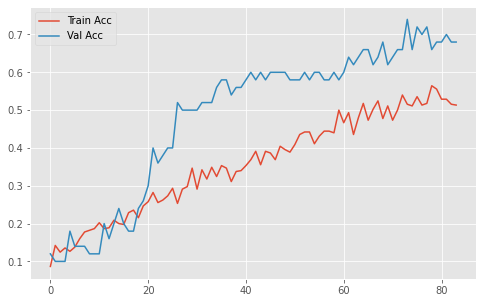

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 4.48	Accuracy: 13.778	Val_Loss: 2.302	Val_Acc: 16.000
Epoch[   1] Test Accuracy: 12.530
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 7 of 10
INFO: Early stopping counter 8 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 1 of 10
Epoch[  51] Loss: 1.51	Accuracy: 46.667	Val_Loss: 1.110	Val_Acc: 70.000
Epoch[  51] Test Accuracy: 68.780
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early

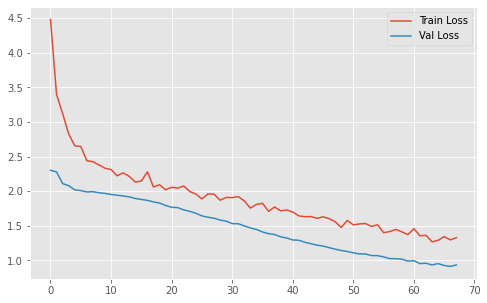

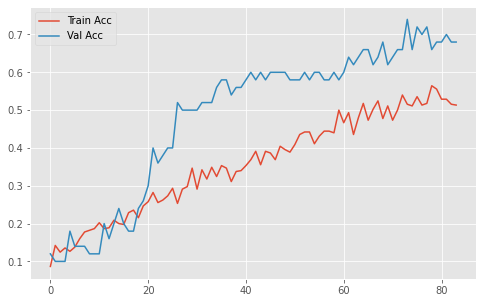

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 4.90	Accuracy: 7.111	Val_Loss: 2.494	Val_Acc: 14.000
Epoch[   1] Test Accuracy: 12.660
Epoch[  51] Loss: 1.47	Accuracy: 47.111	Val_Loss: 1.157	Val_Acc: 58.000
Epoch[  51] Test Accuracy: 67.070
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 7 of 10
INFO: Early stopping counter 8 of 10
INFO: Early stopping counter 9 of 10
INFO: Early stopping counter 10 of 10
INFO: Early stopping
Trained for 74 Epochs.


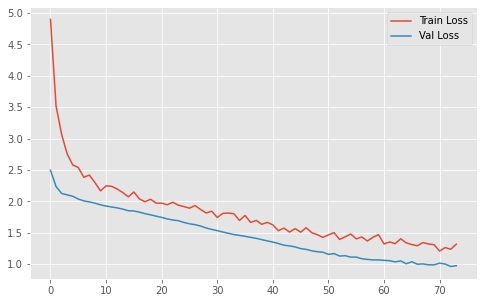

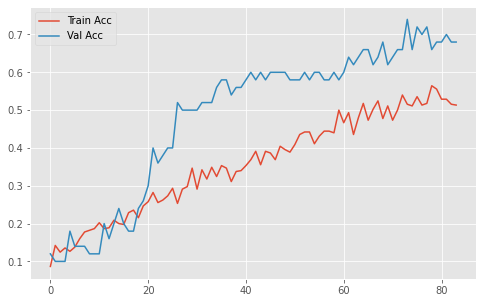

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 5.67	Accuracy: 7.111	Val_Loss: 2.375	Val_Acc: 6.000
Epoch[   1] Test Accuracy: 14.100
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 1 of 10
Epoch[  51] Loss: 1.68	Accuracy: 39.333	Val_Loss: 1.420	Val_Acc: 70.000
Epoch[  51] Test Accuracy: 62.690
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 7 of 10
INFO: Early stopping counter 8 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early s

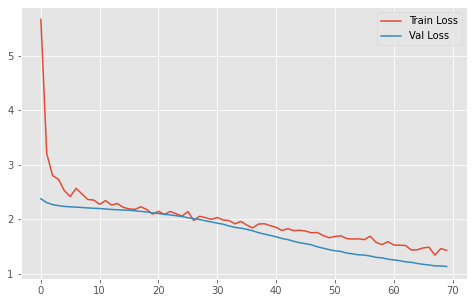

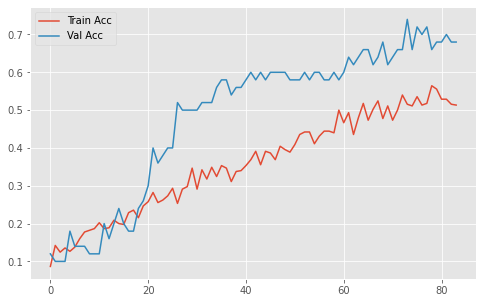

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 5.31	Accuracy: 14.444	Val_Loss: 2.890	Val_Acc: 6.000
Epoch[   1] Test Accuracy: 10.650
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 1 of 10
Epoch[  51] Loss: 1.58	Accuracy: 42.000	Val_Loss: 1.355	Val_Acc: 68.000
Epoch[  51] Test Accuracy: 64.160
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 6 of 10
INFO: Early stopping counter 7 of 10
INFO: Early stopping counter 8 of 10
INFO: Early stopping counter 9 of 10
INFO: Early stopping counter 10 of 10
INFO: Early stopping
Trained for 62 Epochs.


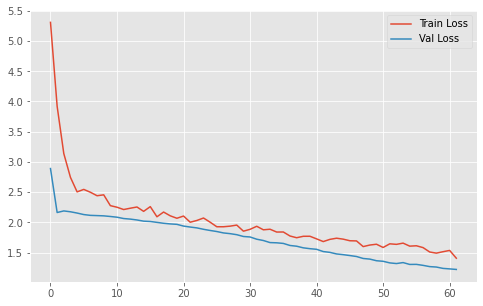

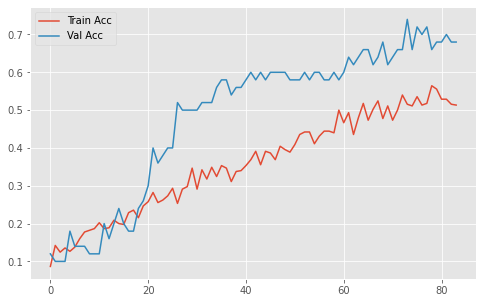

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch[   1] Loss: 5.45	Accuracy: 11.111	Val_Loss: 2.993	Val_Acc: 12.000
Epoch[   1] Test Accuracy: 9.900
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
Epoch[  51] Loss: 1.70	Accuracy: 38.444	Val_Loss: 1.312	Val_Acc: 62.000
Epoch[  51] Test Accuracy: 57.800
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 5 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early stopping counter 1 of 10
INFO: Early stopping counter 2 of 10
INFO: Early stopping counter 3 of 10
INFO: Early stopping counter 4 of 10
INFO: Early 

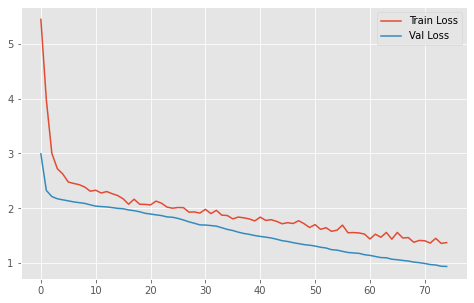

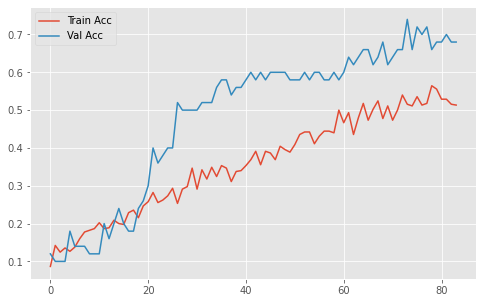

In [61]:
for i in tqdm(range(10)):

    ### Dataset
    inds = randint(0, 60000, (topn,))
    transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    data = Subset(MNIST("./", transform=transform, download=True), inds)
    test_data = MNIST("./", False, transform=transform, download=True)
    images, labels = next(iter(DataLoader(data, len(data), shuffle=True)))
    images = images.reshape(len(data), -1).to(Device)
    labels = labels.to(Device)

    val_size = int(0.1*labels.shape[0])
    sections = (labels.shape[0]-val_size, val_size)
    train_images, val_images = split(images, sections)
    train_labels, val_labels = split(labels, sections)

    test_loader = DataLoader(test_data, batch_size=200, num_workers=2, pin_memory=True)

    ### Model
    layers = get_layers()
    model = nn.Sequential(*layers).to(Device)
    model.apply(init_weights)

    ### Train Utils
    lr = 0.05
    optimizer = SGD(model.parameters(), lr=lr, weight_decay=0.01)
    criterion = nn.NLLLoss()

    Epochs = 500

    ### Train Loop
    early_stopping = EarlyStopping()
    losses2, accs2, val_losses2, val_accs2 = [], [], [], []
    for epoch in tqdm(range(Epochs)):
        model.train()
        optimizer.zero_grad(set_to_none=True)
        output = model(train_images)
        loss = criterion(output, train_labels)
        loss.backward()
        optimizer.step()
        losses2.append(loss.item())
        acc = output.argmax(dim=1).eq(train_labels).float().mean().item()
        accs2.append(acc)
        val_loss, val_acc = val(val_images, val_labels, model, criterion)
        val_losses2.append(val_loss.item())
        val_accs2.append(val_acc)
        early_stopping(val_acc)
        # print(f"Epoch[{epoch+1:4}] Val_Loss: {val_loss:.3f}\tVal_Acc: {val_acc:.3f}")
        if epoch % 50 == 0:
            
            correct = test(test_loader, model)
            print(f"Epoch[{epoch+1:4}] Loss: {loss.item():.2f}\tAccuracy: {acc*100 :.3f}\tVal_Loss: {val_loss:.3f}\tVal_Acc: {val_acc*100:.3f}")
            print(f"Epoch[{epoch+1:4}] Test Accuracy: {(correct / len(test_data))*100 :.3f}")
        if early_stopping.early_stop:
            print(f"Trained for {epoch+1} Epochs.")
            break

    plt.figure(figsize=(8,5))
    plt.plot(losses2, label="Train Loss")
    plt.plot(val_losses2, label="Val Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.legend()
    plt.show()

    model.eval()
    output = model(train_images)
    acc = output.argmax(dim=1).eq(train_labels).float().mean().item()
    Rand_Train_Acc.append(acc*100)
    correct = test(test_loader, model)
    Rand_Val_Acc.append((correct / len(test_data))*100)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(losses2, label="Train Loss")
plt.plot(val_losses2, label="Val Loss")
plt.legend()
plt.savefig("LossCurve_random100")
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.savefig("AccCurve_random100")
plt.show()

In [62]:
model.eval()
correct = test(test_loader, model)
print(correct, 'correctly labeled out of', len(test_data))
print('Accuracy on Test Set:', correct / len(test_data) * 100)

6546 correctly labeled out of 10000
Accuracy on Test Set: 65.46


In [63]:
print(f"Mean Train Accuracy on Random 100 Train Samples is {np.mean(Rand_Train_Acc):.4f}±{np.std(Rand_Train_Acc):.2f}%")
print(f"Mean Val   Accuracy on Random 100 Train Samples is {np.mean(Rand_Val_Acc):.4f}±{np.std(Rand_Val_Acc):.2f}%")

Mean Train Accuracy on Random 100 Train Samples is 75.9333±5.05%
Mean Val   Accuracy on Random 100 Train Samples is 68.8040±3.55%
